## Analysis of timing of green light on

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker

In [2]:
# === CONFIGURATION ===
csv_file = "experiment_data/PI-FL_OD_run_data_042525.csv"    # FL/OD data
out_file = "bluetooth_log_files/test_042525_bltout.out"         # .out control signal log
well_label = "SP2_1"                         # Label of well to analyze
well_index = 1                             # Index of well in light signal string (0-based)
interval_length = 10                         # Time bin size (minutes)
control_duration = 8                         # Duration of control interval (minutes)
time_limit = 400                             # Time limit for plot (minutes)
st_pt_1 = 11500                             # Set point 1 value
st_pt_2 = 18500                             # Set point 1 value

In [3]:
# === STEP 1: Load FL/OD Data ===
data = pd.read_csv(csv_file)
time = data["Time"]
signal_series = data[well_label]

In [4]:
# === STEP 2: Parse .out File and Label Intervals ===
timestamps = []
signals = []
interval_types = []

with open(out_file, 'r') as file:
    lines = file.readlines()

i = 0
while i < len(lines) - 1:
    line = lines[i].strip()
    if "Writing" in line:
        try:
            timestamp_str, signal_str = line.split(": Writing ")
            timestamp = float(timestamp_str) / 60  # seconds to minutes
            signal_str = signal_str.strip()
            if len(signal_str) == 16:
                timestamps.append(timestamp)
                signals.append(signal_str)
                if all(c == 'o' for c in signal_str):
                    interval_types.append('measurement')
                else:
                    interval_types.append('control')
        except ValueError:
            pass
        i += 2
    else:
        i += 1

df_out = pd.DataFrame({
    'time_min': timestamps,
    'signal': signals,
    'interval_type': interval_types
})

In [5]:
# === STEP 3: Filter for Control Intervals and Compute Duty Cycle ===
df_control = df_out[df_out["interval_type"] == "control"].copy()

sample_interval = df_control["time_min"].diff().median() if len(df_control) > 1 else 0.5 / 60
num_bins = int(np.ceil(df_control["time_min"].max() / interval_length))

green_durations = [0.0 for _ in range(num_bins)]
for _, row in df_control.iterrows():
    t = row["time_min"]
    bin_idx = int(t // interval_length)
    if row["signal"][well_index] == 'g':
        green_durations[bin_idx] += sample_interval

duty_cycle = [(g / control_duration) * 100 for g in green_durations]
duty_times = [i * interval_length + control_duration / 2 for i in range(num_bins)]
duty_vals = duty_cycle

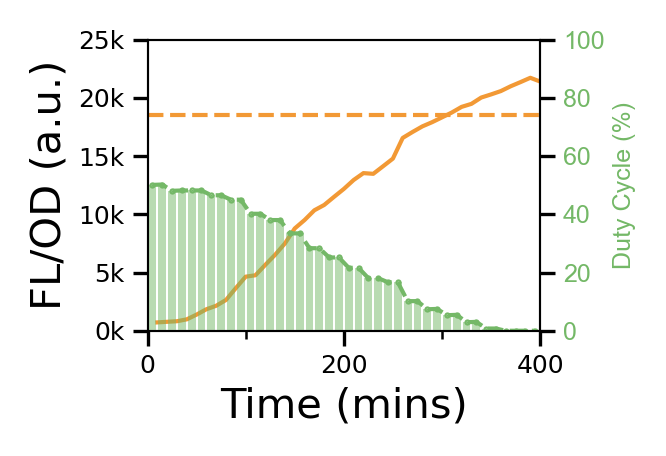

In [6]:
fig, ax1 = plt.subplots(figsize=(2.2, 1.5), dpi = 300)

# Style
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 6,
    'axes.labelsize': 6,
    'axes.titlesize': 6,
    'legend.fontsize': 6
})

flod_color = 'black'            # Color for FL/OD signal
duty_color = '#74B867'           # Color for duty cycle line and shading
st_pt_1_color = '#A06AAF'       # Color for set point 1
st_pt_2_color = '#F29935'       # Color for set point 2
marker_size = 0.5                # Marker size for duty cycle plot
tick_font_size = 6  # <-- user can modify this value

# Line width and alpha
lwd_model = 1
alp = 0.5

# Plot FL/OD signal
ax1.plot(time, signal_series, color = st_pt_2_color, linewidth = lwd_model, label=f'{well_label} (E9)')
ax1.set_xlabel('Time (mins)', labelpad=2)
ax1.set_ylabel('FL/OD (a.u.)', color=flod_color, labelpad=2)
ax1.tick_params(axis='y', labelcolor=flod_color, pad=2)
ax1.set_xlim(0, time_limit)
ax1.set_ylim(0, 25000)
ax1.minorticks_on()
ax1.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(100))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(5000))

# Draw horizontal lines at correct setpoints
ax1.axhline(y = st_pt_2, linestyle = '--', color = st_pt_2_color, linewidth = lwd_model)

# Format y-axis ticks as "5k", "10k", etc.
def thousands_formatter(x, pos):
    return f'{int(x/1000)}k'

ax1.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

max_bar_height = 100  # Adjust this scale as needed


valid_start, valid_end = 1, 1 + control_duration



# Secondary y-axis: Duty Cycle
ax2 = ax1.twinx()
duty_times = [i * interval_length + (valid_start + valid_end) / 2
              for i in range(len(duty_cycle)) if i * interval_length < time_limit]
duty_vals = [dc for i, dc in enumerate(duty_cycle) if i * interval_length < time_limit]
ax2.plot(duty_times, duty_vals, color=duty_color, marker='o',
         markersize=marker_size, linestyle='--', linewidth=lwd_model, label='Duty Cycle (%)')
ax2.set_ylabel("Duty Cycle (%)", color=duty_color, labelpad=2)
ax2.tick_params(axis='y', labelcolor=duty_color, pad=2)
ax2.set_ylim(0, 100)

for i, dc in enumerate(duty_cycle):
    start = i * interval_length + valid_start
    end = i * interval_length + valid_end
    if start < time_limit:
        bar_height = (dc / 100) * max_bar_height
        ax2.fill_between([start, end],
                         y1=0,
                         y2=bar_height,
                         color=duty_color,
                        #  alpha=dc / 100 * alp,
                        alpha = alp,
                         linewidth = 0)

# Axis ticks
#ax1.set_xticks([0, 60, 120, 180, 240, 300])

# Legend
#ax1.legend(loc='upper left', frameon=False)

# Spine styling
spine_width = 0.5
for ax in [ax1, ax2]:
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_linewidth(spine_width)
    ax.tick_params(axis='both', which='major', labelsize = tick_font_size, pad=2)
#ax1.set_title('Duty cycle variation in close-loop system')

# Layout
plt.tight_layout()
#plt.savefig('figures/duty_cycle_dynamics_SP2_1_PI.svg', format='svg', dpi=300, bbox_inches='tight', transparent=True)